In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.utils as utils
import keras.optimizers as optim
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D,
    Dense, Flatten,
    Dropout, BatchNormalization
)
from keras.metrics import CategoricalAccuracy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
!kaggle competitions download -c mds-ufu-dl-test

mds-ufu-dl-test.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
!unzip mds-ufu-dl-test.zip

Archive:  mds-ufu-dl-test.zip
replace fmnist_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Helpers



In [118]:
# Constants
BATCH_SIZE = 64
IMG_DIMENSION = 28
CLASSES = 10
LR = 1e-3
EPOCHS=10

def preprocess_images(images):
  n = images.shape[0]
  images_reshaped = images.reshape(n, IMG_DIMENSION, IMG_DIMENSION, 1)
  images_reshaped /= 255.0

  return images_reshaped

def target_to_categorical(y):
  return utils.to_categorical(y, CLASSES)

def validate_model(model, X, y):
  metrics = model.evaluate(X, y)
  print('Model loss:', metrics[0])
  print('Model accuracy:', metrics[1])

def plot_train_history(history, fig_size=(8, 6)):
  fig, ax = plt.subplots(figsize=fig_size)
  ax.plot(history['categorical_accuracy'], label='train')
  ax.plot(history['val_categorical_accuracy'], label='test')
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch')
  ax.legend()

  fig.suptitle('History')

## Загрузим данные

In [119]:
train = pd.read_csv("fmnist_train.csv", sep=",")
test = pd.read_csv("fmnist_test.csv", sep=",")
submission = pd.read_csv("sample_submission.csv", sep=",")

In [120]:
train_filled = train.fillna(method='ffill')
test_filled = test.fillna(method='ffill')

In [121]:
train_filled

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17035,4,0,0,0,0,0,0,0,1,0,...,186.0,16.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,17035
17036,4,0,0,0,0,0,0,5,4,3,...,0.0,33.0,48.0,37.0,3.0,0.0,0.0,0.0,0.0,17036
17037,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17037
17038,6,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17038


In [122]:
train_filled["label"].value_counts() # Плюс минус одинаково - это хорошо

0    1770
7    1761
3    1725
6    1704
1    1700
5    1695
9    1694
2    1677
8    1675
4    1639
Name: label, dtype: int64

## Проверим пропуски

In [123]:
cols_to_transform = train_filled.select_dtypes(include="float64").columns

train_casted = train_filled.copy()
test_casted = test_filled.copy()
train_casted[cols_to_transform] = train_filled[cols_to_transform].astype(np.float16)
test_casted[cols_to_transform] = test_filled[cols_to_transform].astype(np.float16)

In [124]:
train_casted.info(), test_casted.info() # Отлично уменьшили размер в ~15 раз. Надеюсь не будет проблем с совместимостью типов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17040 entries, 0 to 17039
Columns: 786 entries, label to Id
dtypes: float16(424), int64(362)
memory usage: 60.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, pixel1 to Id
dtypes: float16(424), int64(361)
memory usage: 35.6 MB


(None, None)

### Преобразуем данные и взглянем на изображения

Text(0.5, 0.98, 'Image examples')

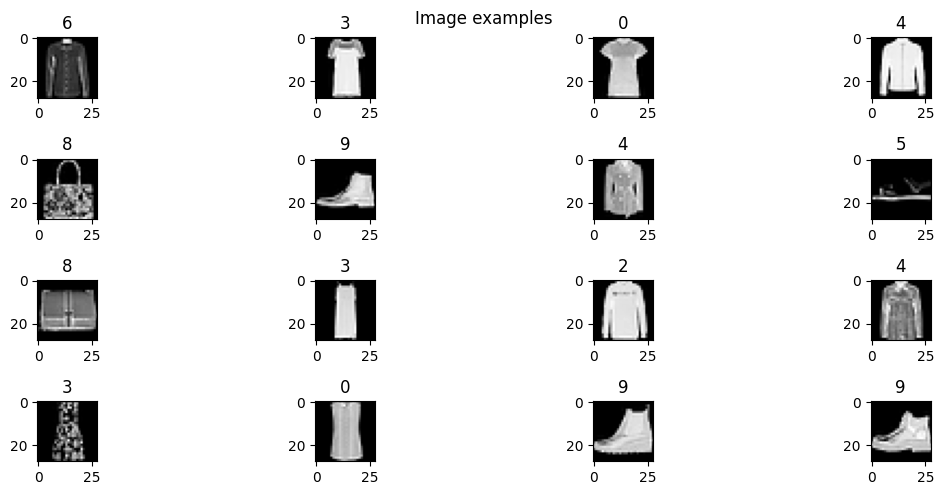

In [125]:
_indices = np.random.randint(0, len(train_casted), size=(16,))
_images = train_casted.iloc[_indices, 1:-1].values
_labels = train_casted.iloc[_indices, 0].values

fig = plt.figure(figsize=(15,5))
for i, (image, label) in enumerate(zip(_images, _labels)):
  ax = fig.add_subplot(4, 16//4, i+1)
  ax.imshow(image.reshape(IMG_DIMENSION, IMG_DIMENSION), cmap='gray')
  ax.set_title(label)
  fig.tight_layout()

fig.suptitle('Image examples')

# Вроде все ок

In [126]:
# Подготовим данные для того чтобы скормить их модели
X, y = preprocess_images(train_casted.iloc[:, 1:-1].values), \
                    target_to_categorical(train_casted.iloc[:, 0].values) # Not shuffled it's important

X.shape, y.shape # Кажется все ок

((17040, 28, 28, 1), (17040, 10))

In [127]:
# Подготовим тренировочную и тестовую выборку

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape # Гуд

((13632, 28, 28, 1), (3408, 28, 28, 1), (13632, 10), (3408, 10))

In [128]:
def _create_model() -> Sequential: # Попробуем вот такие параметры
  model = Sequential()

  model.add(
    Conv2D(
      16, kernel_size=(3, 3),
      activation='gelu',
      padding='same',
      input_shape=(IMG_DIMENSION, IMG_DIMENSION, 1)
    )
  )
  model.add(
      BatchNormalization()
  )

  model.add(
    Conv2D(
      32, kernel_size=(3, 3),
      activation='gelu',
      padding='same',
      # input_shape=(IMG_DIMENSION, IMG_DIMENSION, 1)
    )
  )
  model.add(
      MaxPooling2D(2, 2)
  )
  model.add(Dropout(0.25))
  model.add(
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='gelu')   
  )
  model.add(
      MaxPooling2D(2, 2)
  )
  model.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
  model.add(
      MaxPooling2D(2, 2)
  )
  model.add(Flatten())
  model.add(Dense(256, activation='gelu'))
  model.add(Dropout(0.25))
  model.add(Dense(CLASSES, activation='softmax'))

  return model

model = _create_model()

model.compile(
    optim.Adam(learning_rate=LR),
    categorical_crossentropy,
    metrics=[CategoricalAccuracy()]
)

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_38 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_83 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_58 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_84 (Conv2D)          (None, 14, 14, 64)      

Epoch 1/10
213/213 [==============================] - 3s 10ms/step - loss: 0.6136 - categorical_accuracy: 0.7796 - val_loss: 1.7854 - val_categorical_accuracy: 0.7567
Epoch 2/10
213/213 [==============================] - 2s 9ms/step - loss: 0.3628 - categorical_accuracy: 0.8668 - val_loss: 0.6448 - val_categorical_accuracy: 0.7955
Epoch 3/10
213/213 [==============================] - 2s 8ms/step - loss: 0.3028 - categorical_accuracy: 0.8860 - val_loss: 0.3014 - val_categorical_accuracy: 0.8897
Epoch 4/10
213/213 [==============================] - 2s 8ms/step - loss: 0.2555 - categorical_accuracy: 0.9044 - val_loss: 0.2825 - val_categorical_accuracy: 0.8958
Epoch 5/10
213/213 [==============================] - 2s 11ms/step - loss: 0.2195 - categorical_accuracy: 0.9178 - val_loss: 0.2996 - val_categorical_accuracy: 0.8955
Epoch 6/10
213/213 [==============================] - 2s 9ms/step - loss: 0.1981 - categorical_accuracy: 0.9252 - val_loss: 0.2877 - val_categorical_accuracy: 0.8973
Ep

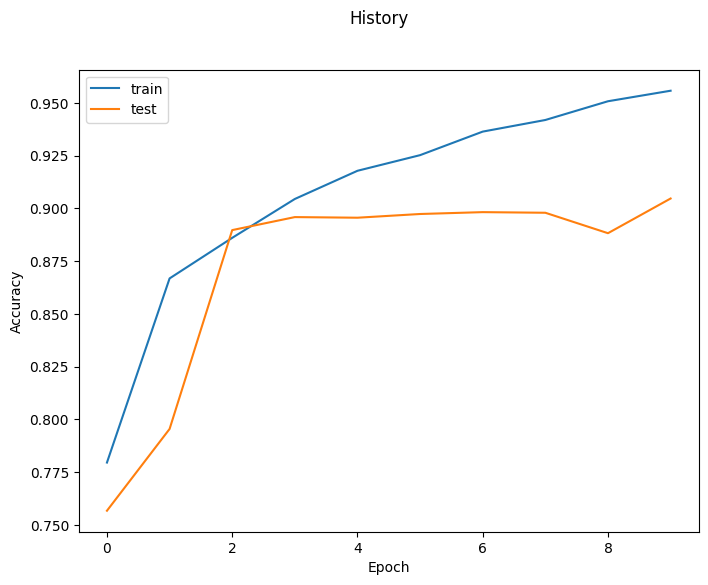

In [129]:
## Обучим модель
_history = model.fit(
    x=X_train, y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test, y_test)
)

plot_train_history(_history.history) # По графику наверно можно сказать что есть все же переобучение

In [130]:
validate_model(model, X_test, y_test) # Неплохо, но переобучились слегка

107/107 [==============================] - 0s 3ms/step - loss: 0.3265 - categorical_accuracy: 0.9046
Model loss: 0.3265490233898163
Model accuracy: 0.9046361446380615


In [131]:
def _create_modelv2() -> Sequential: # Попробуем вот такие параметры
  model = Sequential()
  model.add(
    Conv2D(
      16, kernel_size=(3, 3),
      activation='gelu',
      padding='same',
      input_shape=(IMG_DIMENSION, IMG_DIMENSION, 1)
    )
  )
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(
    Conv2D(
      32, kernel_size=(3, 3),
      activation='gelu',
      padding='same',
    )
  )
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.15))
  model.add(
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='gelu')   
  )
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2, 2))

  model.add(Flatten())
  model.add(Dense(256, activation='gelu'))
  model.add(Dropout(0.35))
  model.add(Dense(CLASSES, activation='softmax'))

  return model

modelv2 = _create_modelv2()

modelv2.compile(
    optim.Adam(learning_rate=LR),
    categorical_crossentropy,
    metrics=[CategoricalAccuracy()]
)

modelv2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_39 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 dropout_60 (Dropout)        (None, 28, 28, 16)        0         
                                                                 
 conv2d_87 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 batch_normalization_40 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 14, 14, 32)     

Epoch 1/10
213/213 [==============================] - 4s 12ms/step - loss: 0.7749 - categorical_accuracy: 0.7248 - val_loss: 6.4021 - val_categorical_accuracy: 0.0983
Epoch 2/10
213/213 [==============================] - 2s 10ms/step - loss: 0.4972 - categorical_accuracy: 0.8145 - val_loss: 2.5321 - val_categorical_accuracy: 0.4240
Epoch 3/10
213/213 [==============================] - 2s 10ms/step - loss: 0.4256 - categorical_accuracy: 0.8447 - val_loss: 0.5160 - val_categorical_accuracy: 0.8143
Epoch 4/10
213/213 [==============================] - 2s 10ms/step - loss: 0.3777 - categorical_accuracy: 0.8600 - val_loss: 0.3516 - val_categorical_accuracy: 0.8650
Epoch 5/10
213/213 [==============================] - 2s 10ms/step - loss: 0.3451 - categorical_accuracy: 0.8718 - val_loss: 0.3327 - val_categorical_accuracy: 0.8697
Epoch 6/10
213/213 [==============================] - 2s 11ms/step - loss: 0.3138 - categorical_accuracy: 0.8818 - val_loss: 0.3001 - val_categorical_accuracy: 0.886

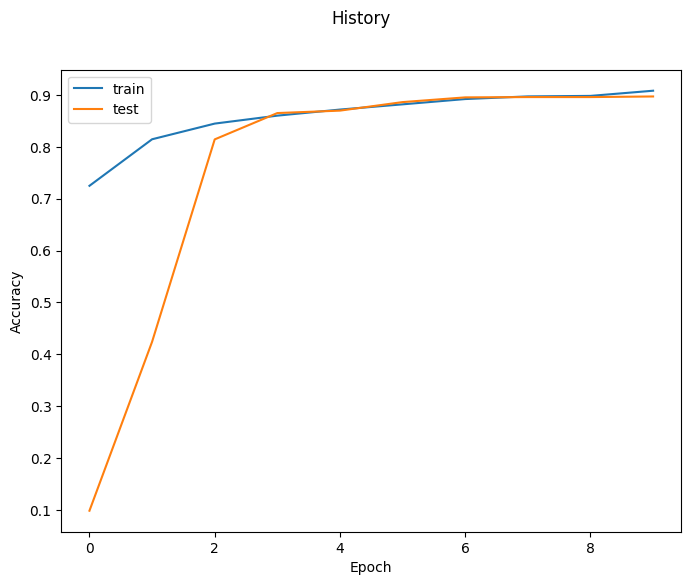

In [132]:
_historyV2 = modelv2.fit(
    x=X_train, y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test, y_test)
)

plot_train_history(_historyV2.history) # Отлично по графику мы избавились от переобучения, а значит на новых данных будем точнее

In [133]:
validate_model(modelv2, X_test, y_test) # Удалось избавиться от переобучения, при этом сохранить относительно высокую точность 

107/107 [==============================] - 0s 3ms/step - loss: 0.2867 - categorical_accuracy: 0.8970
Model loss: 0.2867323160171509
Model accuracy: 0.8970070481300354


## Submit

In [134]:
X_test = preprocess_images(test_casted.iloc[:, :-1].values)
X_test.shape, len(test_casted) # Ок

((10000, 28, 28, 1), 10000)

In [137]:
predictions = modelv2.predict(X_test) 
predictions_classes = np.argmax(predictions, axis=1)
# predictions.shape
predictions_classes.shape

313/313 [==============================] - 1s 4ms/step


(10000,)

In [145]:
## Отправим результаты
submission = pd.DataFrame(data=predictions_classes, columns=['Category'], index=test_casted.iloc[:, -1])
submission

,Category
Id,
0,0
1,1
2,2
3,6
4,3
...,...
9995,0
9996,6
9997,8


In [146]:
submission.to_csv("my_submission.csv", sep=',', index='Id')

In [147]:
!kaggle competitions submit -c mds-ufu-dl-test -f my_submission.csv -m "first try"

100% 67.3k/67.3k [00:03<00:00, 17.5kB/s]
Successfully submitted to [MDS-UFU-DL-TEST] Построение классификатора